# What is this notebook about

This notebook builds upon the notebooks ``` spacenet6_masking.ipynb ``` and ``` spacenet6_resize.ipynb ```

``` spacenet6_masking.ipynb ``` is used to generate all the masks for all 3401 training images, using only the PAN images and geojson_buildings files. These masks will be the same regardless of the original data format, hence it is a run-once-and-forget

``` spacenet6_resize.ipynb ``` is used to resize images to the appropriate size and data format, depending on the output resolution wanted for training. Most research papers utilise a 256x256 resolution as a sufficient size for unet applications. This should be run before running this notebook to set up the files needed



This notebook utilises the default model for ssatellite-unet found from https://pypi.org/project/keras-unet/#usage-examples, as well as the focal-loss module from https://pypi.org/project/focal-loss/

This notebook has performed well for PS-RGB images at 256x256 resolution, running a 25 epoch cycle and getting reasonable accuracy and results 

# Setup COLAB and imports

In [ ]:
''' Used to reference the root directory, for directory traversal '''
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
! pip install rasterio

     |████████████████████████████████| 18.2MB 1.8MB/s 


In [ ]:
import rasterio
from rasterio.plot import show, reshape_as_raster, reshape_as_image

from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image

import os
import numpy as np
from pathlib import Path
from tqdm import tqdm 
import copy

# Global

In [ ]:
''' get the same random set every time '''
seed = 42
np.random.seed = seed


''' we will be resizing to this for the unet '''
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
DTYPE_SRC = np.uint16
DTYPE_TARGET = np.uint8


''' setting the amount of data we want to use '''
SIZE_TRAIN = 3000    # folder has 3401
SIZE_TEST = 401      # folder has 401

In [ ]:
''' change in accordance to the image type and dimensions '''
COMBI = 'psrgb_256x256_uint16'


''' Get the directories for this combination '''
PATH_DATA = Path(root_dir + '/spacenet6/spacenet6_data/' + COMBI)
PATH_TRAIN = PATH_DATA/'train'
PATH_MASK = PATH_DATA/'mask'
PATH_TEST = PATH_DATA/'test'

# Get the data

In [ ]:
# Grab the filenames from files that were prepared
# TEST_MASK is only available because we did not make use of the full set for train. full set is 3401 images

''' Get all, sort, then take a subset and make a copy '''
_train_ids = next(os.walk(PATH_TRAIN))[2]
_mask_ids = next(os.walk(PATH_MASK))[2]
_test_ids = next(os.walk(PATH_TEST))[2]
_test_mask_ids = next(os.walk(PATH_MASK))[2]

_train_ids.sort()
_mask_ids.sort()
_test_ids.sort()
_test_mask_ids.sort()

train_ids = copy.deepcopy(_train_ids[:SIZE_TRAIN])
mask_ids = copy.deepcopy(_mask_ids[:SIZE_TRAIN])
test_ids = copy.deepcopy(_test_ids[:SIZE_TEST]) 
test_mask_ids = copy.deepcopy(_test_mask_ids[SIZE_TRAIN:SIZE_TRAIN+SIZE_TEST])

print(len(train_ids))
print(train_ids[:3])
print(len(mask_ids))
print(mask_ids[:3])
print(len(test_ids))
print(test_ids[:3])
print(len(test_mask_ids))
print(test_mask_ids[:3])

3000
['SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8679.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8681.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8683.tif']
3000
['SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8681.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8683.tif']
401
['SN6_Train_AOI_11_Rotterdam_PS-RGB_20190823141628_20190823141922_tile_8743.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190823141628_20190823141922_tile_8744.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190823142111_20190823142355_tile_3933.tif']


In [ ]:
# x: image data    y: mask data
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=DTYPE_TARGET)
Y_train = np.zeros((len(mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=DTYPE_TARGET)
Y_test = np.zeros((len(test_mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('X_train', X_train.shape, X_train.dtype)
print('Y_train', Y_train.shape, Y_train.dtype)
print('X_test', X_test.shape, X_test.dtype)
print('Y_test', Y_test.shape, Y_test.dtype)

X_train (3000, 256, 256, 3) uint8
Y_train (3000, 256, 256, 1) bool
X_test (401, 256, 256, 3) uint8


In [ ]:
''' format images into uint8 format and save into array '''

print('formatting training images')
for n, id in tqdm(enumerate(train_ids), total=len(train_ids), position=0, leave=True):
  img = image.load_img(PATH_TRAIN/id, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img = image.img_to_array(img, dtype=DTYPE_TARGET)
  X_train[n] = img
print('Finished formatting training images')

print('formatting mask images')
for n, id in tqdm(enumerate(mask_ids), total=len(mask_ids), position=0, leave=True):
  img = image.load_img(PATH_MASK/id, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img = image.img_to_array(img, dtype=np.bool)
  img = reshape_as_raster(img)[0] # all three layers are the same, just grab the first layer
  img = reshape_as_image(np.expand_dims(img, axis=0)) 
  Y_train[n] = img
print('Finished formatting mask images')

print('formatting test images')
for n, id in tqdm(enumerate(test_ids), total=len(test_ids), position=0, leave=True):
  img = image.load_img(PATH_TEST/id, target_size=(IMG_HEIGHT, IMG_WIDTH))
  x = image.img_to_array(img, dtype=DTYPE_TARGET)
  X_test[n] = x
print('Finished formatting test images')

print('formatting test mask images')
for n, id in tqdm(enumerate(test_mask_ids), total=len(test_mask_ids), position=0, leave=True):
  img = image.load_img(PATH_MASK/id, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img = image.img_to_array(img, dtype=np.bool)
  img = reshape_as_raster(img)[0] # all three layers are the same, just grab the first layer
  img = reshape_as_image(np.expand_dims(img, axis=0)) 
  Y_test[n] = img
print('Finished formatting test mask images')

  0%|          | 0/3000 [00:00<?, ?it/s]

formatting training images


  0%|          | 0/3000 [00:00<?, ?it/s]

Finished formatting training images
formatting mask images


  0%|          | 1/401 [00:00<01:05,  6.14it/s]

Finished formatting mask images
formatting test images


100%|██████████| 401/401 [01:27<00:00,  4.56it/s]

Finished formatting test images


index: 2178
Training set


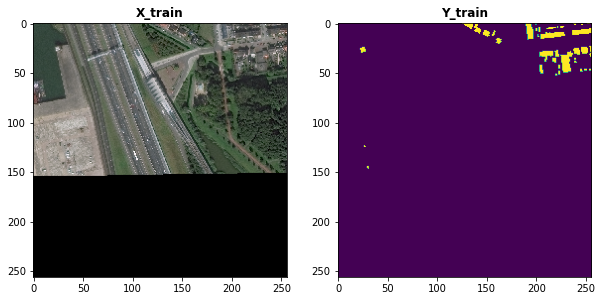

index: 2552
Training set


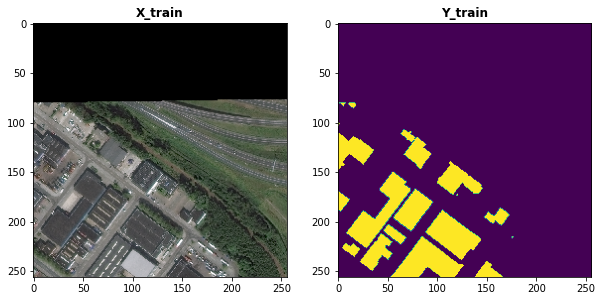

index: 133
Test set


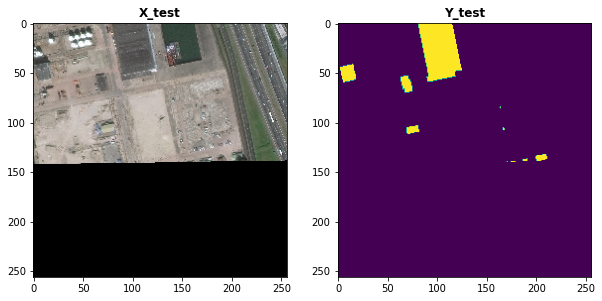

index: 145
Test set


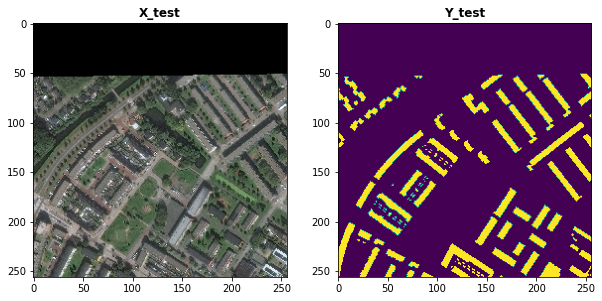

In [ ]:
ix = np.random.randint(0, len(X_train))
print("index: {}".format(ix))
print("Training set")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
show(reshape_as_raster(X_train[ix]), ax=ax1, title='X_train')
show(reshape_as_raster(Y_train[ix]), ax=ax2, title='Y_train')
plt.show()



ix = np.random.randint(0, len(X_train))
print("index: {}".format(ix))
print("Training set")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
show(reshape_as_raster(X_train[ix]), ax=ax1, title='X_train')
show(reshape_as_raster(Y_train[ix]), ax=ax2, title='Y_train')
plt.show()



ix = np.random.randint(0, len(X_test))
print("index: {}".format(ix))
print("Test set")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
show(reshape_as_raster(X_test[ix]), ax=ax1, title='X_test')
show(reshape_as_raster(Y_test[ix]), ax=ax2, title='Y_test')
plt.show()



ix = np.random.randint(0, len(X_test))
print("index: {}".format(ix))
print("Test set")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
show(reshape_as_raster(X_test[ix]), ax=ax1, title='X_test')
show(reshape_as_raster(Y_test[ix]), ax=ax2, title='Y_test')
plt.show()


# Create the model

In [ ]:
! pip install keras_unet
! pip install focal-loss

In [ ]:
from keras import backend as K
from focal_loss import BinaryFocalLoss
from keras_unet.models import satellite_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


Using TensorFlow backend.


In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = satellite_unet(input_shape=(256, 256, 3))
model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=['acc',f1_m,precision_m, recall_m])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_spacenet6.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
169/169 [==============================] - 299s 2s/step - loss: 0.0588 - acc: 0.9249 - f1_m: 0.4393 - precision_m: 0.5817 - recall_m: 0.3976 - val_loss: 0.0351 - val_acc: 0.9516 - val_f1_m: 0.4902 - val_precision_m: 0.8178 - val_recall_m: 0.3551
Epoch 2/25
169/169 [==============================] - 283s 2s/step - loss: 0.0306 - acc: 0.9546 - f1_m: 0.6239 - precision_m: 0.7365 - recall_m: 0.5620 - val_loss: 0.0253 - val_acc: 0.9636 - val_f1_m: 0.7042 - val_precision_m: 0.7825 - val_recall_m: 0.6417
Epoch 3/25
169/169 [==============================] - 283s 2s/step - loss: 0.0261 - acc: 0.9616 - f1_m: 0.6917 - precision_m: 0.7800 - recall_m: 0.6380 - val_loss: 0.0233 - val_acc: 0.9658 - val_f1_m: 0.7386 - val_precision_m: 0.7621 - val_recall_m: 0.7186
Epoch 4/25
169/169 [==============================] - 283s 2s/step - loss: 0.0234 - acc: 0.9652 - f1_m: 0.7236 - precision_m: 0.7965 - recall_m: 0.6773 - val_loss: 0.0220 - val_acc: 0.9677 - val_f1_m: 0.7550 - val_precision_m: 0.

In [ ]:
model.save(PATH_DATA/'model_satellite_unet_25_epoch')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/psrgb_256x256_uint16/model_satellite_unet_25_epoch/assets


In [ ]:
# split train, val 90-10
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

13/13 [==============================] - 11s 856ms/step


### Check results

index: 644
Training set


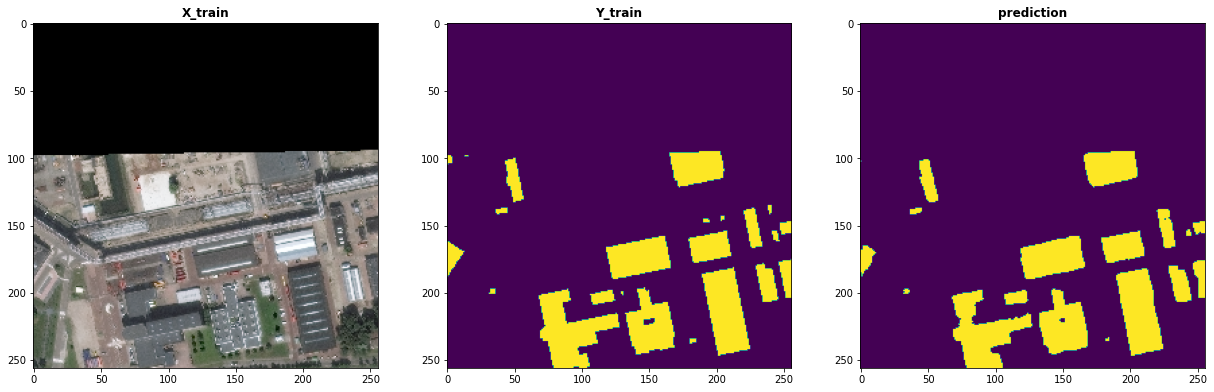

In [ ]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_train_t))
print("index: {}".format(ix))
print("Training set")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,7))
show(reshape_as_raster(X_train[ix]), ax=ax1, title='X_train')
show(reshape_as_raster(Y_train[ix]), ax=ax2, title='Y_train')
show(reshape_as_raster(preds_train_t[ix]), ax=ax3, title='prediction')
plt.show()

index: 24
Validation set


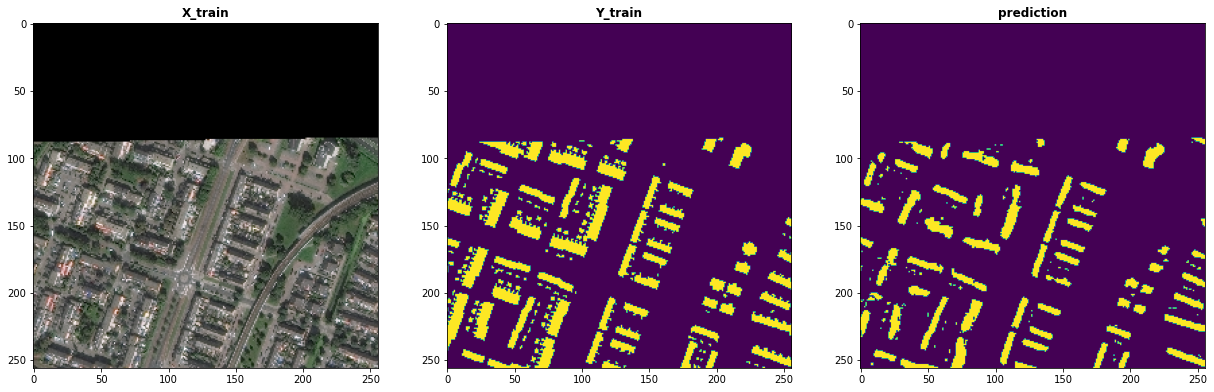

In [ ]:
# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(preds_val_t))
print("index: {}".format(ix))
print("Validation set")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,7))
show(reshape_as_raster(X_train[int(X_train.shape[0]*0.9):][ix]), ax=ax1, title='X_train')
show(reshape_as_raster(Y_train[int(Y_train.shape[0]*0.9):][ix]), ax=ax2, title='Y_train')
show(reshape_as_raster(preds_val_t[ix]), ax=ax3, title='prediction')
plt.show()

index: 382
Test set


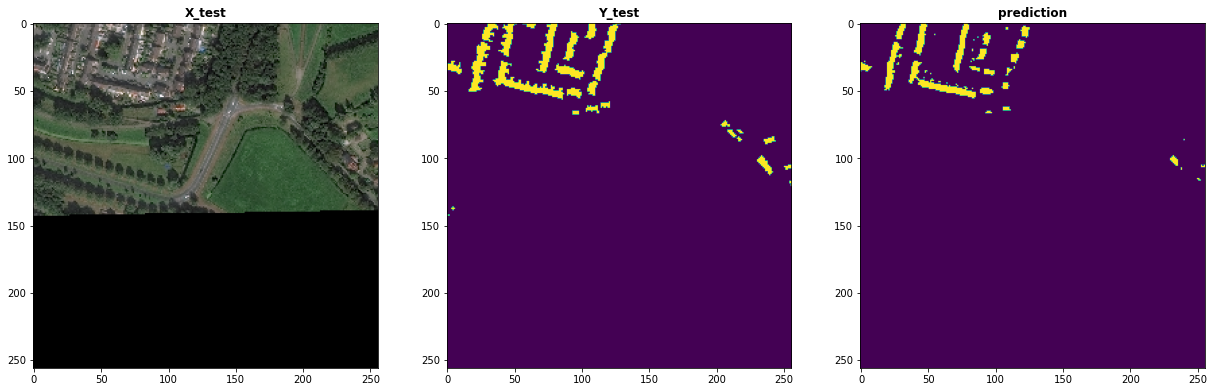

In [ ]:
# Perform a sanity check on some random test samples
ix = np.random.randint(0, len(preds_test_t))
print("index: {}".format(ix))
print("Test set")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,7))
show(reshape_as_raster(X_test[ix]), ax=ax1, title='X_test')
show(reshape_as_raster(Y_test[ix]), ax=ax2, title='Y_test')
show(reshape_as_raster(preds_test_t[ix]), ax=ax3, title='prediction')
plt.show()

1/1 [==============================] - 0s 3ms/step


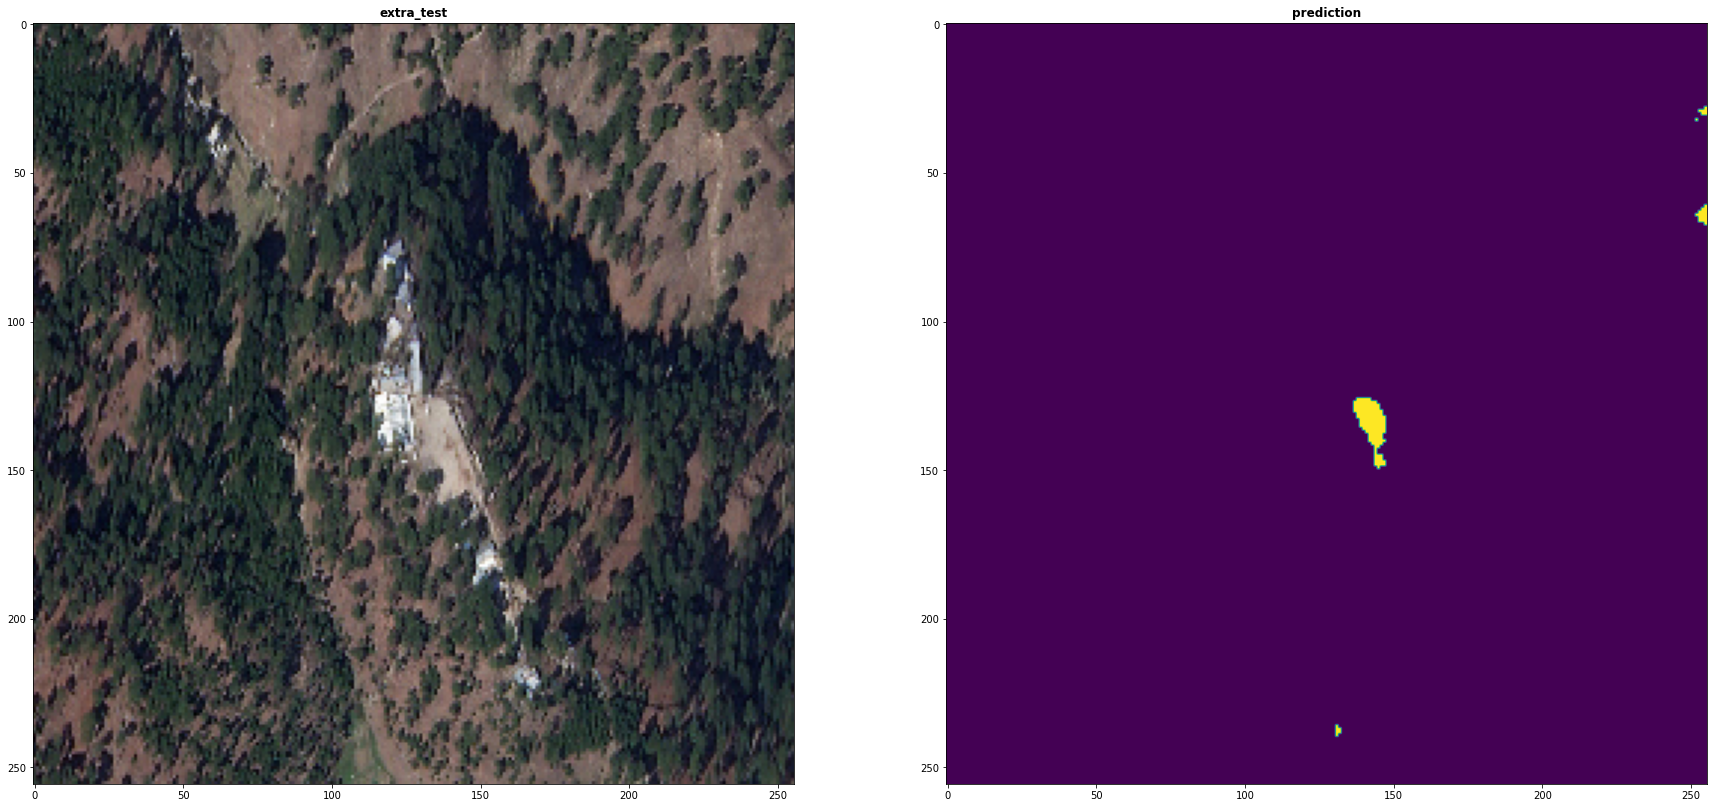

In [ ]:
# Perform on a test on some unknown images
img = image.load_img(PATH_DATA/'extra_img.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH))
img = image.img_to_array(img, dtype=DTYPE_TARGET)
extra_test = np.expand_dims(img, 0)

preds_extra_test = model.predict(extra_test, verbose=1)
preds_extra_test_t = (preds_extra_test > 0.5).astype(np.uint8)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,15))
show(reshape_as_raster(extra_test[0]), ax=ax1, title='extra_test')
show(reshape_as_raster(preds_extra_test_t[0]), ax=ax2, title='prediction')
plt.show()

# TRIAL

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# import numpy as np

# model = ResNet50(weights='imagenet')

# img_path = PATH_DATA/'elephant.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# preds = model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)
# print('Predicted:', decode_predictions(preds, top=3)[0])
# # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357

In [ ]:
img = image.load_img(PATH_MASK/mask_ids[0], target_size=(IMG_HEIGHT, IMG_WIDTH))
x = image.img_to_array(img, dtype=np.bool)
# x = preprocess_input(x)
# (x[0] == x[1]).all()
x = reshape_as_raster(x)[0] # all three layers are the same, just grab the first layer
x = reshape_as_image(np.expand_dims(x, axis=0)) 
x.shape

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])